## Libraries

In [8]:
from gapcv.vision import Image, Images
from keras.callbacks import LambdaCallback
import cv2

Using TensorFlow backend.


In [33]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage

In [10]:
import keras
from keras.applications.vgg16 import VGG16
from keras import backend as K
from keras.models import Sequential, load_model
from keras.layers import activations, BatchNormalization
from keras.layers.core import Flatten, Dense, Dropout
from keras.optimizers import SGD, Adam
from keras.metrics import categorical_crossentropy
from keras import regularizers
from keras.layers.convolutional import *
from keras.callbacks import ModelCheckpoint

In [111]:
import warnings
warnings.filterwarnings(action ='ignore')

## Load Data

#### Data Import via GapMV

In [11]:
images = Images('chinese/ch_train_set/',num_proc='all',config=['nostore','gray'],name='chinese')

In [12]:
def convert_size(row):
    if row == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(row, 1024)))
    p = math.pow(1024, i)
    s = round(row / p, 2)
    return "{} {}".format(s, size_name[i])

In [13]:
images[1]

In [102]:
images[0].data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

#### Data Preprocessing

In [117]:
# via JohnB/MatthewB/AndrewF
def normalize_images(img):
    img //=128
    return img

# via AndrewF
def img_centering(im):
    com = ndimage.measurements.center_of_mass(im)

    # Translation distances in x and y axis
    x_trans = int(im.shape[0]//2-com[0])
    y_trans = int(im.shape[1]//2-com[1])

    # Pad and remove pixels from image to perform translation
    if x_trans > 0:
        im2 = np.pad(im, ((x_trans, 0), (0, 0)), mode='constant')
        im2 = im2[:im.shape[0]-x_trans, :]
    else:
        im2 = np.pad(im, ((0, -x_trans), (0, 0)), mode='constant')
        im2 = im2[-x_trans:, :]

    if y_trans > 0:
        im3 = np.pad(im2, ((0, 0), (y_trans, 0)), mode='constant')
        im3 = im3[:, :im.shape[0]-y_trans]

    else:
        im3 = np.pad(im2, ((0, 0), (0, -y_trans)), mode='constant')
        im3 = im3[:, -y_trans:]

    print(com)
    print(ndimage.measurements.center_of_mass(im3))

    plt.figure(figsize=(2,2))
    img_show=im
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(img_show)
    plt.show()

    plt.figure(figsize=(2,2))
    img_show=im2
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(img_show)
    plt.show()

    plt.figure(figsize=(2,2))
    img_show=im3
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(img_show)
    plt.show()

(21.924603174603174, 38.173280423280424)
(29.441893830703012, 37.955523672883785)


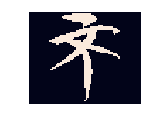

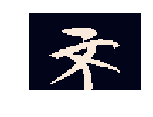

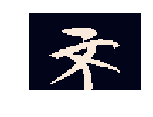

In [120]:
img_centering(images[2000].data)

In [97]:
normalize_images(np.array([50,250,17,100,128]))

array([0, 1, 0, 0, 1])

#### Dataframe Construction

In [15]:
def return_script(i, data):
    try:
        return data.image.split('_')[2].split('-')[1]
    except:
        return "modern"
        

dict_list={i:{'img_class':img.image.split('/')[-2],
              'image':img.image.split('/')[-1],
              'script':return_script(i,img),
              'label':img.label,
              'name':img.name,
              'rawshape':img.rawshape,
              'ressize':img.ressize,
              'size':img.size,
              'shape':img.shape,
              'type':img.type} for i, img in enumerate(images._data)}

# get data frame
train_set=pd.DataFrame(dict_list).T

# fixed data types
train_set['size'] = train_set['size'].astype('int')

train_set['size_max']=train_set['size']
train_set['size_min']=train_set['size']
train_set.head(3)

,image,img_class,label,name,rawshape,ressize,script,shape,size,type,size_max,size_min
0,a440-chuxi_005.png,a440,0,a440-chuxi_005,"(65, 79)",0,chuxi,"(65, 79)",157,png,157,157
1,a440-chuxi_001.png,a440,0,a440-chuxi_001,"(65, 79)",0,chuxi,"(65, 79)",166,png,166,166
2,a440-chuxi_004.png,a440,0,a440-chuxi_004,"(65, 79)",0,chuxi,"(65, 79)",164,png,164,164


In [87]:
train_set.isna().any()

image        False
img_class    False
label        False
name         False
rawshape     False
ressize      False
script       False
shape        False
size         False
type         False
size_max     False
size_min     False
dtype: bool

In [16]:
train_set_grouped=train_set.pivot_table(index=['label','type','shape','img_class','script'],
                   values=['image','size_max','size','size_min'],
                   aggfunc={'image':len,'size_max':max,'size':np.mean,'size_min':min}
                  )

train_set_grouped.reset_index(inplace=True)

train_set_grouped.rename(columns={'size':'size_avg', 'time':'time_avg'}, inplace = True)
train_set_grouped['size_avg']=train_set_grouped.apply(lambda row: convert_size(row['size_avg']), axis=1)
train_set_grouped['size_max']=train_set_grouped.apply(lambda row: convert_size(row['size_max']), axis=1)
train_set_grouped['size_min']=train_set_grouped.apply(lambda row: convert_size(row['size_min']), axis=1)
train_set_grouped.head()

,label,type,shape,img_class,script,image,size_avg,size_max,size_min
0,0,png,"(65, 79)",a440,chuxi,218,161.54 B,223.0 B,130.0 B
1,0,png,"(65, 79)",a440,jinwen,15,135.53 B,171.0 B,96.0 B
2,0,png,"(65, 79)",a440,modern,1,98.0 B,98.0 B,98.0 B
3,0,png,"(65, 79)",a440,smallseal,2,165.5 B,231.0 B,100.0 B
4,1,png,"(65, 79)",a447,chuxi,170,205.68 B,315.0 B,174.0 B


## Data Visualization

In [54]:
images.split = 0.2
X_train, X_test, Y_train, Y_test = images.split

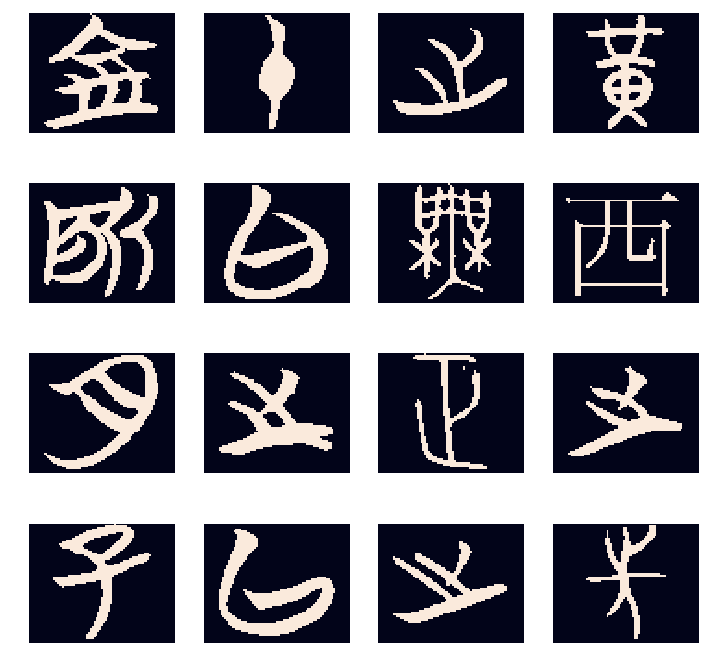

In [55]:
fig=plt.figure(figsize=(12, 12))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    img_show=X_train[i]
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(img_show)
plt.show()

In [77]:
n,c = train_set_grouped['label'].values, train_set_grouped['image'].values

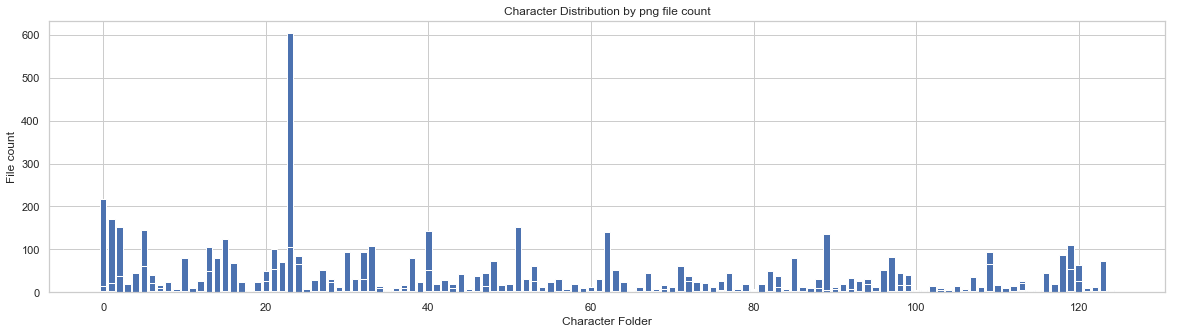

In [81]:
plt.figure(figsize=(20,5))
plt.bar(n,c)
plt.title('Character Distribution by png file count')
plt.xlabel('Character Folder')
plt.ylabel('File count')
plt.show()

In [28]:
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


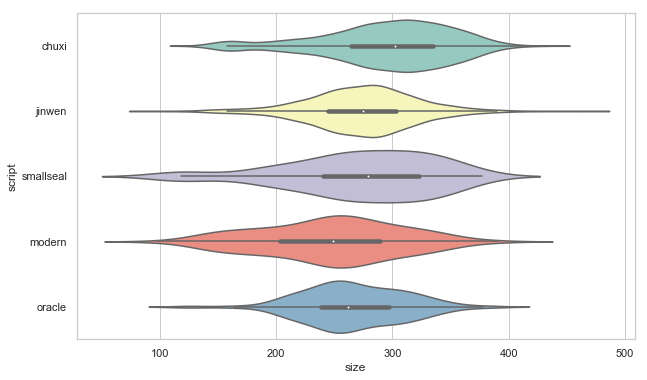

In [41]:
script_set = train_set[['script','size']]
plt.figure(figsize=(10,6))
ax = sns.violinplot(x="size", y="script",data=script_set,scale="width", palette="Set3")
plt.show()

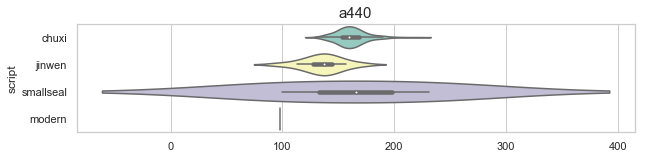

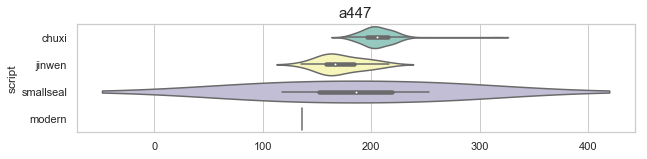

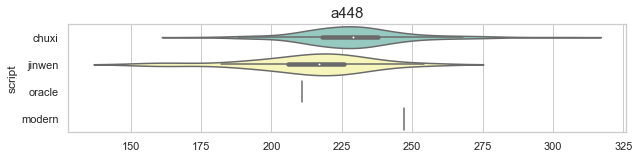

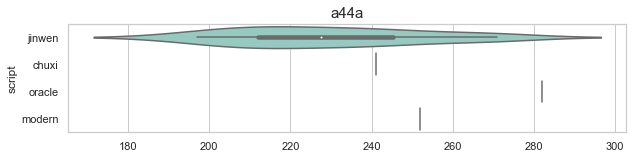

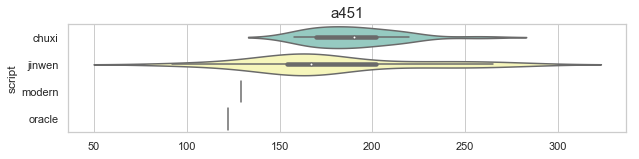

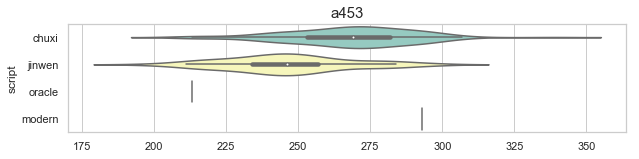

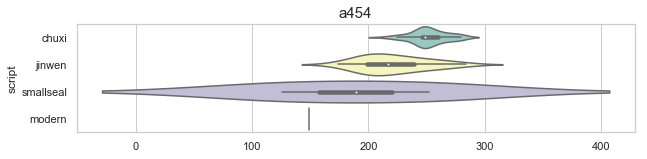

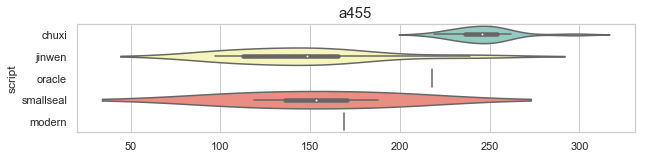

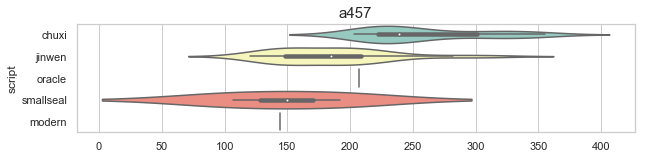

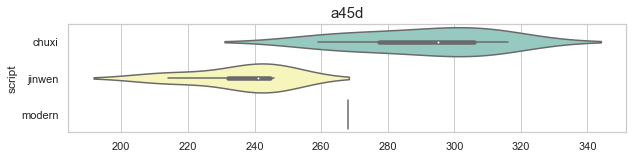

In [95]:
labels = train_set.img_class.unique()[0:10]

for l in labels:
    label_set = train_set[['script','size','img_class']]
    plt.figure(figsize=(10,2))
    plt.title(l,fontsize=15)
    ax = sns.violinplot(x="size", y="script",data=label_set[label_set['img_class']==l],scale="width", palette="Set3")
    plt.xlabel('',fontsize=10)
    plt.show()

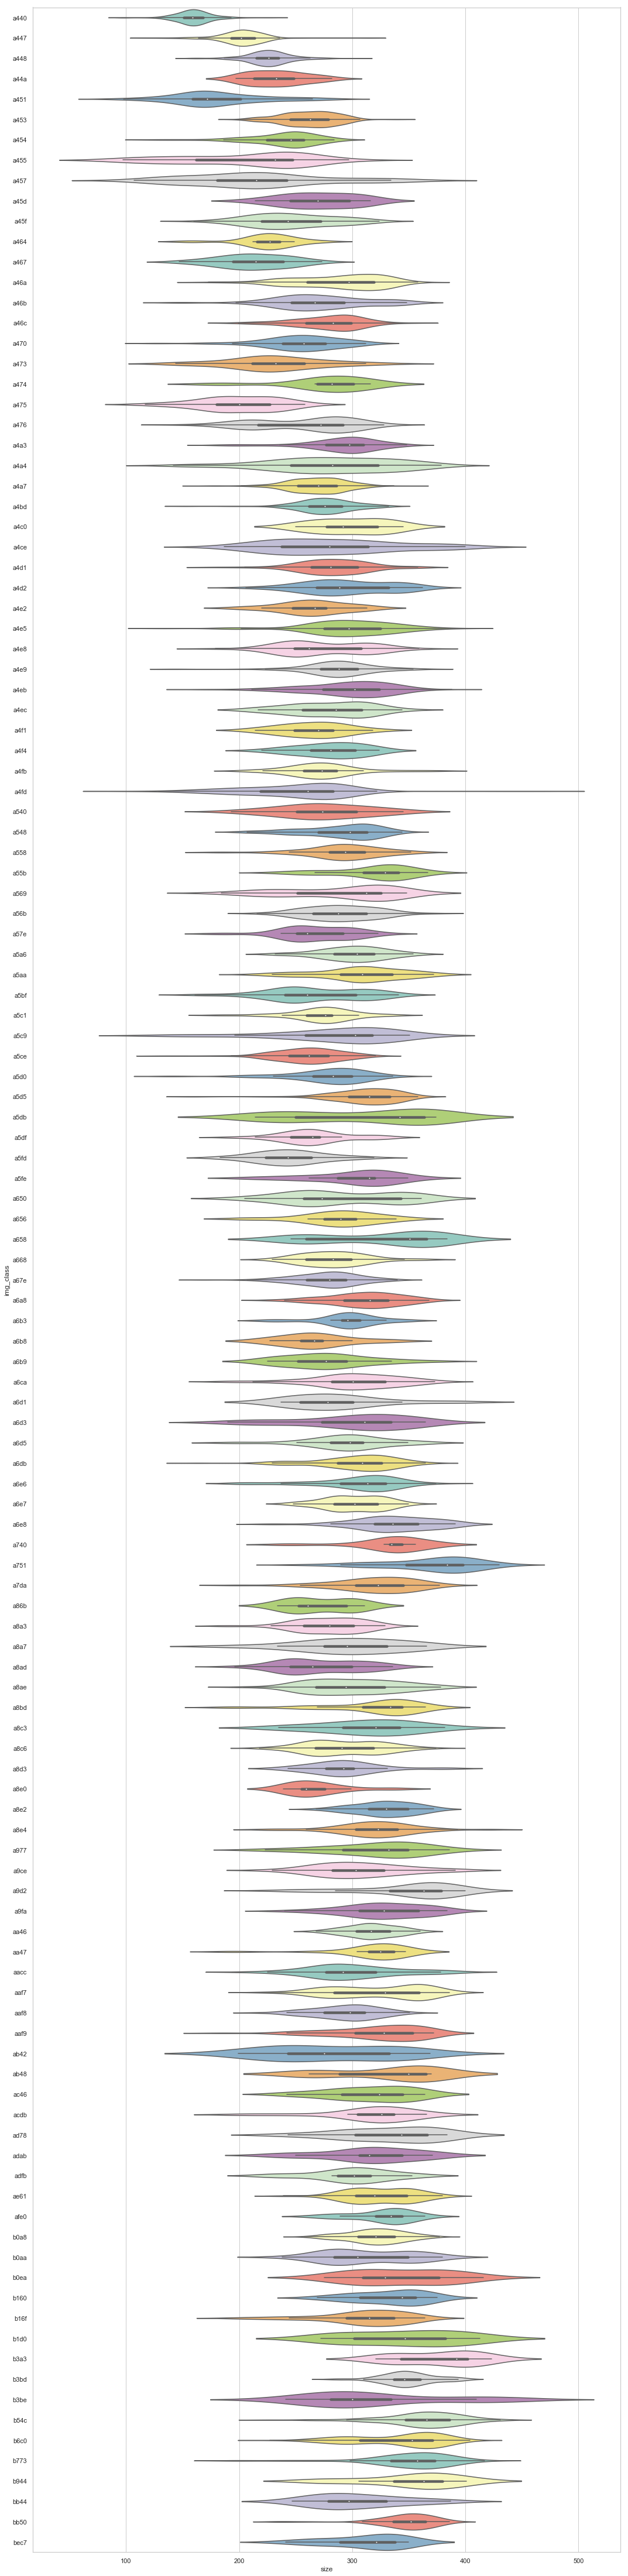

In [47]:
char_set = train_set[['img_class','size']]
plt.figure(figsize=(18,80))
ax = sns.violinplot(x="size", y="img_class",kind='script',data=char_set,scale="width", palette="Set3")

### My Model for Keras (different shape)

In [ ]:
X_train,X_test = X_train.reshape(X_train.shape[0],65,79,1),X_test.reshape(X_test.shape[0],65,79,1)

In [ ]:
batch_size = 64
num_classes = Y_train.shape[1]
epochs = 20
input_shape = X_train.shape[1:]

_Keras Layers template: [MNIST for Beginners](https://www.kaggle.com/adityaecdrid/mnist-with-keras-for-beginners-99457)_

In [ ]:
from keras.callbacks import Callback

In [ ]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',kernel_initializer='RandomNormal',input_shape=(65,79,1,)))
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='RandomNormal', kernel_regularizer=regularizers.l2(0.3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.20))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='RandomNormal', kernel_regularizer=regularizers.l2(0.3)))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='RandomNormal', kernel_regularizer=regularizers.l2(0.2)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu',padding='same',kernel_initializer='RandomNormal',kernel_regularizer=regularizers.l2(0.2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

# checkpoint
# filepath="weights-improvement-{epoch:02d}.hdf5"
# checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=True, mode='max')
# print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(model.layers[0].get_weights()))

# callbacks_list = [checkpoint]



model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

In [ ]:
model.fit(X_train,Y_train,epochs=3)

In [ ]:
model.evaluate(X_test,Y_test)

In [ ]:
prediction_set = Images('chinese/ch_test/', config=['nostore','gray'])
final_images = np.array([im._imgdata.reshape(65,79,1) for im in prediction_set._data[:]])
final_labels = np.array([im.name for im in prediction_set])
pred = model.predict(final_images)

In [ ]:
actual_labels = df2['img_class'].values
actual_label = [prediction_set[i].name for i in range(len(prediction_set))]
pred_label = [final_labels[p.argmax()] for p in pred]

In [ ]:
v = 0
for i in range(20):
    if actual_label[i] == pred_label[i]:
        v+=1
        print('{}: CORRECT!'.format(i))
    else:
        print('{}: WRONG!'.format(i))
# print(v,v/200)

In [ ]:
im=Image('chinese/19981.gif',config=['resize=(65,79)','gray'])
im = im.data.reshape(65,79,1)
im = np.expand_dims(im,axis=0)
pred = model.predict(im).argmax()
actual_labels[pred]

In [ ]:
im=Image('chinese/a4a3-real.jpg',config=['resize=(65,79)','gray'])
im = im.data.reshape(65,79,1)
im = np.expand_dims(im,axis=0)
pred = model.predict(im).argmax()
actual_labels[pred]